In [1]:
# %% Import packages
from pprint import pprint
from itertools import chain, compress, product
from functools import reduce, partial, lru_cache
from glob import iglob
from typing import Generator

import pandas as pd
from numba import jit
from yaml import safe_load
from cytoolz import compose, merge_with
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
import altair as alt

from dltools import load_combiner
from dltools.sacla import restructure, load_analyzer

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [2]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "4g")
    .config("spark.driver.memory", "4g")
    .config("spark.driver.maxResultSize", "2g")
    .config(        
        "spark.jars.packages",
        "org.mongodb.spark:mongo-spark-connector_2.11:2.3.1,"
        "org.diana-hep:spark-root_2.11:0.1.15,"
    )
)

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [3]:
# %% Load data
from pyspark.sql.types import (
    ArrayType, BooleanType, LongType, StructField, StructType, DoubleType,
)
from dltools import SpkHits


print("Loading data...")
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [35, 36]},
                gm2: {$gte: 0.005, $lt: 0.013},
            },
        },
        {
            $project: {
                tag: true,
                hits: {
                    $filter: {
                        input: "$hits",
                        as: "item",
                        cond: {$lte: ["$$item.flag", 6]},
                    },
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("hits", SpkHits)
        ])
    )
    .load()
)
df.printSchema()
print("Done!")

Loading data...
root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)

Done!


In [4]:
from dltools.cov import cov11_simple, cov11, cov21


pipico = cov11_simple(
    df.select(f.col("hits.t").alias("t")),
    "t",
)
tof = cov11(
    df.select(f.col("hits.t").alias("t")),
    "t",
)
fish = cov21(
    df.select(f.col("hits.t").alias("t"),
              f.col("hits.y").alias("y")),
    "t", "y",
)

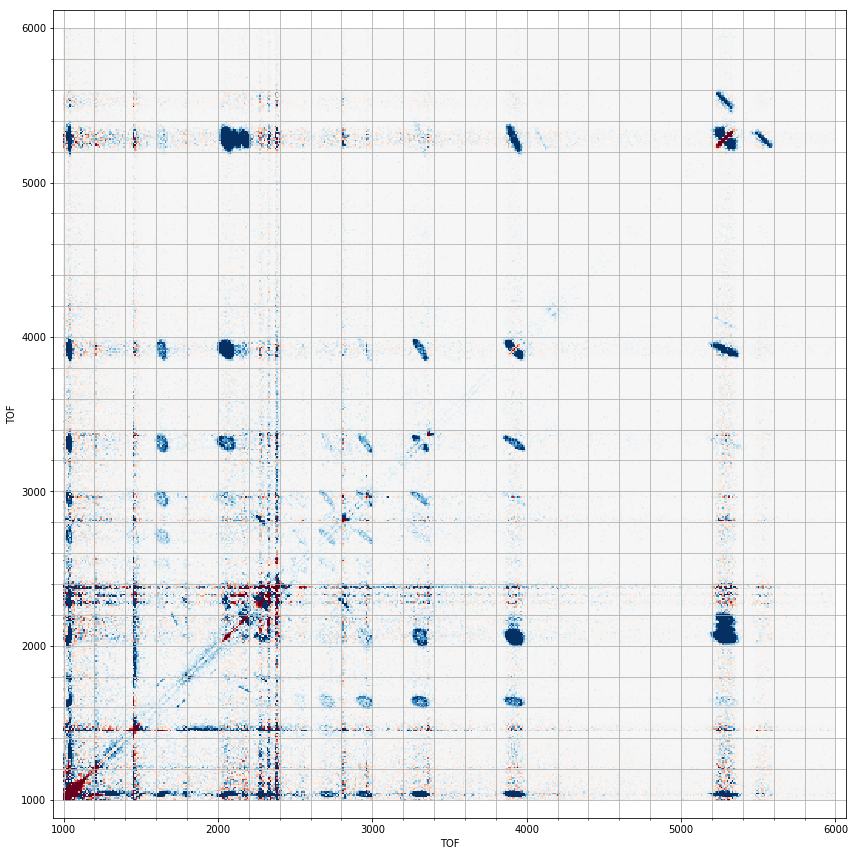

In [9]:
fr, to, nbins = 1000, 6000, 500
img = pipico(fr, to, nbins)["Cov[X,Y]"]
tbins = np.linspace(fr, to, nbins + 1)
clim = 1e-4

plt.figure(figsize=(12, 12))
plt.xlabel("TOF")
plt.ylabel("TOF")
plt.pcolormesh(tbins, tbins, img.T, cmap="RdBu")
plt.clim(-clim, clim)
plt.minorticks_on()
plt.grid(True, which="both")
plt.axis("equal")

plt.tight_layout()
# plt.savefig("Figures/aq035--aq036; Covariant PIPICO.pdf")
plt.show()

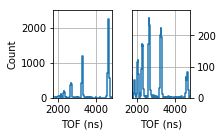

In [5]:
fr, to, nbins = 1000, 6000, 250
x = np.linspace(fr, to, nbins + 1) - 650

plt.figure(figsize=(3.2, 2))
plt.subplot(121)
d = tof(
    fr, to, nbins,
    fr1=1950, to1=2150)  # C1p
arr = d["Cov[X,Y]"][..., 0] * d["N"]
plt.xlabel("TOF (ns)")
plt.ylabel("Count")
plt.step(x[1:], arr)
plt.xlim(1750, 4800)
plt.ylim(0, 2500)
plt.grid(True)
plt.gca().label_outer()

plt.subplot(122)
d = tof(
    fr, to, nbins,
    fr1=1580, to1=1700)  # C2p
arr = d["Cov[X,Y]"][..., 0] * d["N"]
plt.xlabel("TOF (ns)")
# plt.ylabel("Count")
plt.step(x[1:], arr)
plt.xlim(1750, 4800)
plt.ylim(0, 280)
plt.gca().yaxis.tick_right()
plt.grid(True)
plt.tight_layout()
plt.show()

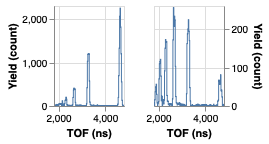

In [52]:
fr, to, nbins = 1000, 6000, 250  # 20
t0 = 650
edges = np.linspace(fr, to, nbins + 1)

d = tof(
    fr, to, nbins,
    fr1=1950, to1=2150)  # C1p
df = pd.DataFrame({
    "TOF from (ns)": edges[:-1] - t0,
    "TOF to (ns)": edges[1:] - t0,
    "TOF (ns)": (edges[:-1] + edges[1:]) / 2 - t0,
    "Yield (count)": d["Cov[X,Y]"][..., 0] * d["N"],
})

fig0 = alt.Chart(df, width=70, height=100).mark_line(interpolate="step", strokeWidth=1, clip=True).encode(
    alt.X(
        "TOF (ns)",
        scale=alt.Scale(domain=[1800, 4800], nice=False),
    ),
    alt.Y(
        "Yield (count)",
        scale=alt.Scale(domain=[0, 2300], nice=False),
    ),
)

d = tof(
    fr, to, nbins,
    fr1=1580, to1=1700)  # C2p
df = pd.DataFrame({
    "TOF from (ns)": edges[:-1] - t0,
    "TOF to (ns)": edges[1:] - t0,
    "TOF (ns)": (edges[:-1] + edges[1:]) / 2 - t0,
    "Yield (count)": d["Cov[X,Y]"][..., 0] * d["N"],
})

fig1 = alt.Chart(df, width=70, height=100).mark_line(interpolate="step", strokeWidth=1, clip=True).encode(
    alt.X(
        "TOF (ns)",
        scale=alt.Scale(domain=[1800, 4800], nice=False),
    ),
    alt.Y(
        "Yield (count)",
        scale=alt.Scale(domain=[0, 260], nice=False),
        axis=alt.Axis(orient="right")
    ),
)
fig0 | fig1

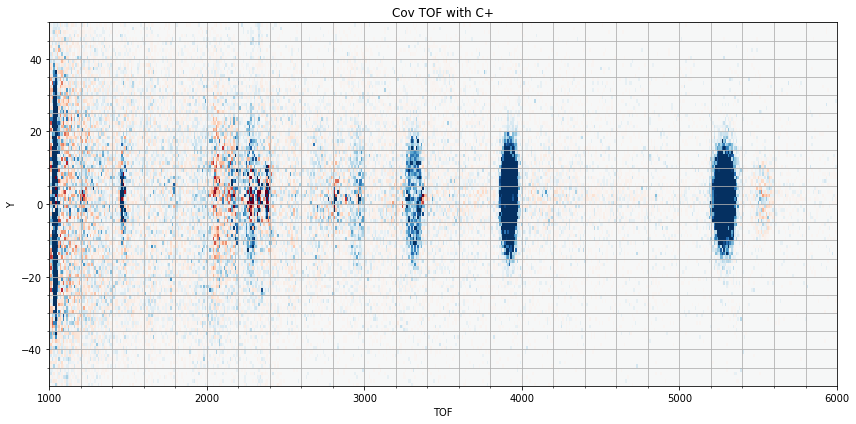

In [39]:
fr, to, nbins = 1000, 6000, 500
tbins = np.linspace(fr, to, nbins + 1)
rbins = np.linspace(-50, 50, 101)
clim = 5e-5

img = fish(
    fr, to, nbins,
    fr01=-50, to01=50, nbins01=101,
    fr1=1950, to1=2150,  # C1p
)["Cov[X,Y]"][..., 0]

plt.figure(figsize=(12, 6))
plt.title("Cov TOF with C+")
plt.xlabel("TOF")
plt.ylabel("Y")
plt.pcolormesh(tbins, rbins, img.T, cmap="RdBu")
plt.clim(-clim, clim)
plt.minorticks_on()
plt.grid(True, which="both")
plt.tight_layout()
plt.show()

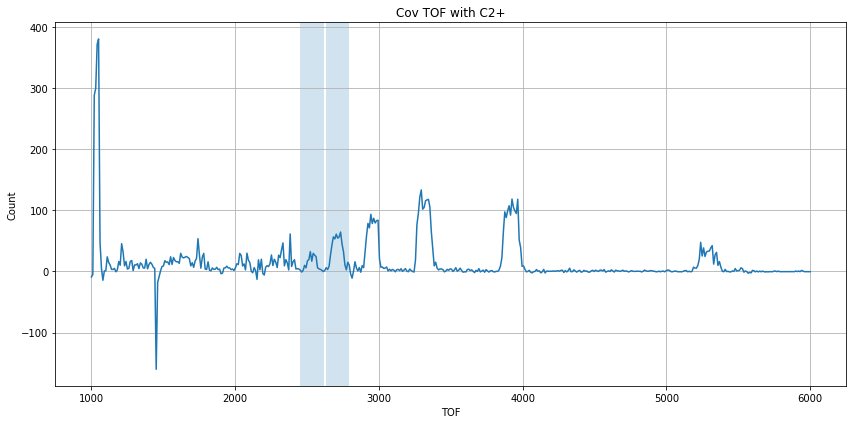

In [97]:
fr, to, nbins = 1000, 6000, 500
d = tof(
    fr, to, nbins,
    fr1=1580, to1=1700)  # C2p
arr = d["Cov[X,Y]"][..., 0] * d["N"]

plt.figure(figsize=(12, 6))
plt.title("Cov TOF with C2+")
plt.xlabel("TOF")
plt.ylabel("Count")
plt.plot(np.linspace(fr, to, nbins), arr)
plt.axvspan(2630, 2790, alpha=0.2)  # 150
plt.axvspan(2450, 2620, alpha=0.2)  # 130
# plt.yscale("log")
# plt.ylim(0, None)
plt.grid(True)
plt.tight_layout()
plt.show()

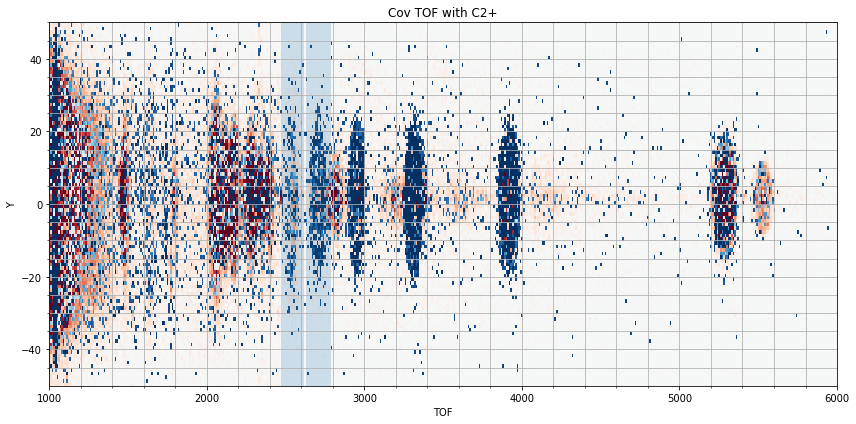

In [96]:
fr, to, nbins = 1000, 6000, 500
tbins = np.linspace(fr, to, nbins + 1)
rbins = np.linspace(-50, 50, 101)
clim = 5e-6

img = fish(
    fr, to, nbins,
    fr01=-50, to01=50, nbins01=101,
    fr1=1580, to1=1700,  # C2p
)["Cov[X,Y]"][..., 0]
img.shape

plt.figure(figsize=(12, 6))
plt.title("Cov TOF with C2+")
plt.xlabel("TOF")
plt.ylabel("Y")
plt.pcolormesh(tbins, rbins, img.T, cmap="RdBu")
plt.axvspan(2630, 2790, alpha=0.2)  # 150
plt.axvspan(2470, 2620, alpha=0.2)  # 130
plt.clim(-clim, clim)
plt.minorticks_on()
plt.grid(True, which="both")
plt.tight_layout()
plt.show()

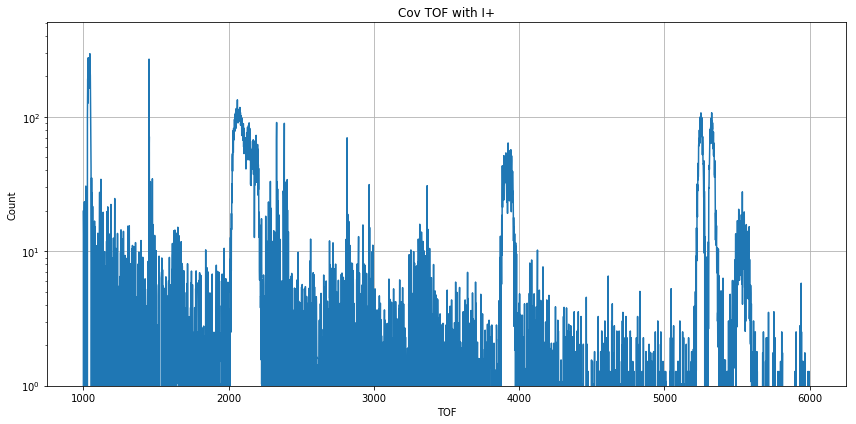

In [29]:
fr, to, nbins = 1000, 6000, 5000
d = tof(
    fr, to, nbins,
    fr1=5150, to1=5420)  # I1p
arr = d["Cov[X,Y]"][..., 0] * d["N"]

plt.figure(figsize=(12, 6))
plt.title("Cov TOF with I+")
plt.xlabel("TOF")
plt.ylabel("Count")
plt.plot(np.linspace(fr, to, nbins), arr)
plt.yscale("log")
plt.ylim(1, None)
plt.grid(True)
plt.tight_layout()
plt.show()

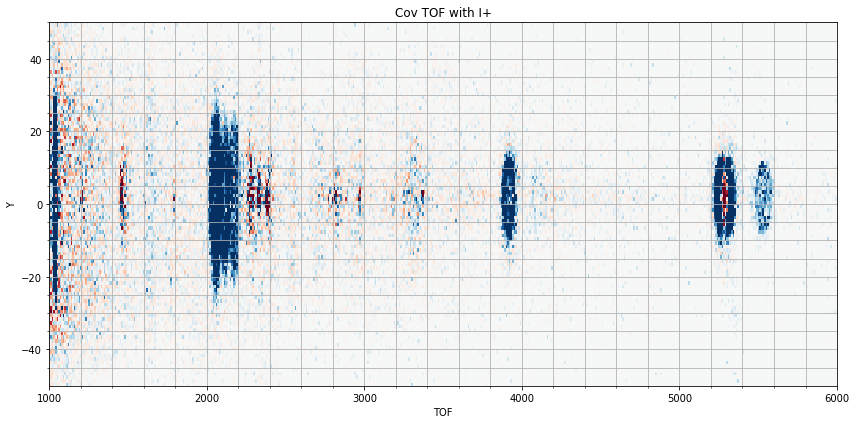

In [41]:
fr, to, nbins = 1000, 6000, 500
tbins = np.linspace(fr, to, nbins + 1)
rbins = np.linspace(-50, 50, 101)
clim = 5e-5

img = fish(
    fr, to, nbins,
    fr01=-50, to01=50, nbins01=101,
    fr1=5150, to1=5420,  # I1p
)["Cov[X,Y]"][..., 0]
img.shape

plt.figure(figsize=(12, 6))
plt.title("Cov TOF with I+")
plt.xlabel("TOF")
plt.ylabel("Y")
plt.pcolormesh(tbins, rbins, img.T, cmap="RdBu")
plt.clim(-clim, clim)
plt.minorticks_on()
plt.grid(True, which="both")
plt.tight_layout()
plt.show()

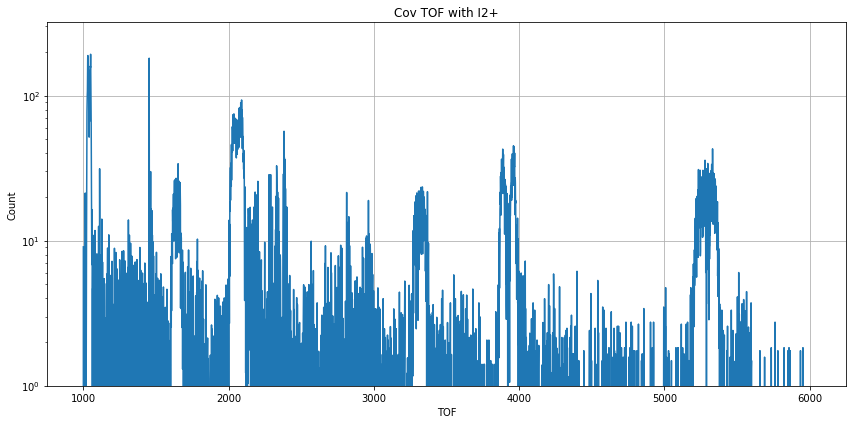

In [30]:
fr, to, nbins = 1000, 6000, 5000
d = tof(
    fr, to, nbins,
    fr1=3800, to1=4020)  # I2p
arr = d["Cov[X,Y]"][..., 0] * d["N"]

plt.figure(figsize=(12, 6))
plt.title("Cov TOF with I2+")
plt.xlabel("TOF")
plt.ylabel("Count")
plt.plot(np.linspace(fr, to, nbins), arr)
plt.yscale("log")
plt.ylim(1, None)
plt.grid(True)
plt.tight_layout()
plt.show()

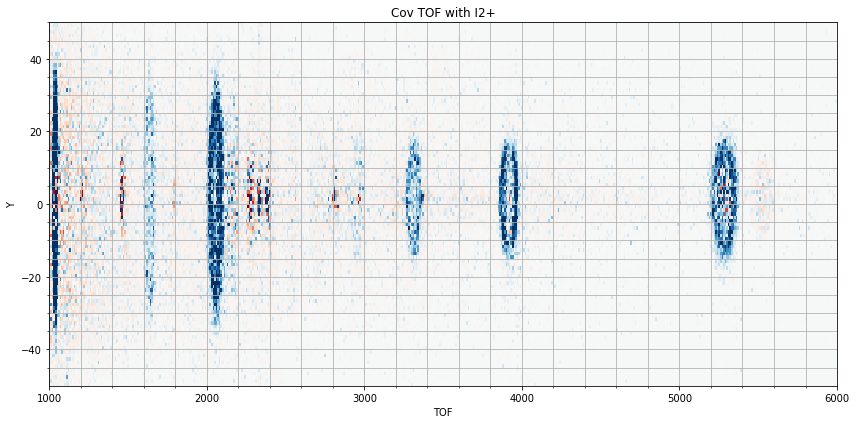

In [42]:
fr, to, nbins = 1000, 6000, 500
tbins = np.linspace(fr, to, nbins + 1)
rbins = np.linspace(-50, 50, 101)
clim = 5e-5

img = fish(
    fr, to, nbins,
    fr01=-50, to01=50, nbins01=101,
    fr1=3800, to1=4020,  # I2p
)["Cov[X,Y]"][..., 0]
img.shape

plt.figure(figsize=(12, 6))
plt.title("Cov TOF with I2+")
plt.xlabel("TOF")
plt.ylabel("Y")
plt.pcolormesh(tbins, rbins, img.T, cmap="RdBu")
plt.clim(-clim, clim)
plt.minorticks_on()
plt.grid(True, which="both")
plt.tight_layout()
plt.show()

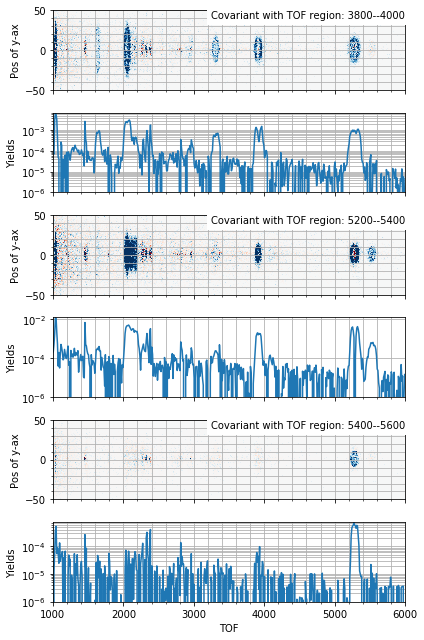

In [12]:
fr, to, nbins = 1000, 6000, 500
tbins = np.linspace(fr, to, nbins + 1)
tcenters = (tbins[1:] + tbins[:-1]) / 2
rbins = np.linspace(-50, 50, 101)
clim = 5e-5

plt.figure(figsize=(6, 9))
plt.subplot(611)
plt.text(1, 1, "Covariant with TOF region: 3800--4000",
         horizontalalignment="right",
         verticalalignment="top",
         transform=plt.gca().transAxes,
         bbox={"facecolor": "w", "edgecolor": "w"})
plt.ylabel("Pos of y-ax")
img = fish(
    fr, to, nbins,
    fr01=-50, to01=50, nbins01=101,
    fr1=3800, to1=4000,
)["Cov[X,Y]"][..., 0]
plt.pcolormesh(tbins, rbins, img.T, cmap="RdBu")
plt.clim(-clim, clim)
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.subplot(612)
plt.ylabel("Yields")
plt.plot(tcenters, img.sum(1))
plt.xlim(1000, 6000)
plt.ylim(1e-6, None)
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.subplot(613)
plt.text(1, 1, "Covariant with TOF region: 5200--5400",
         horizontalalignment="right",
         verticalalignment="top",
         transform=plt.gca().transAxes,
         bbox={"facecolor": "w", "edgecolor": "w"})
plt.ylabel("Pos of y-ax")
img = fish(
    fr, to, nbins,
    fr01=-50, to01=50, nbins01=101,
    fr1=5200, to1=5400,
)["Cov[X,Y]"][..., 0]
plt.pcolormesh(tbins, rbins, img.T, cmap="RdBu")
plt.clim(-clim, clim)
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.subplot(614)
plt.ylabel("Yields")
plt.plot(tcenters, img.sum(1))
plt.xlim(1000, 6000)
plt.ylim(1e-6, None)
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.subplot(615)
plt.text(1, 1, "Covariant with TOF region: 5400--5600",
         horizontalalignment="right",
         verticalalignment="top",
         transform=plt.gca().transAxes,
         bbox={"facecolor": "w", "edgecolor": "w"})
plt.ylabel("Pos of y-ax")
img = fish(
    fr, to, nbins,
    fr01=-50, to01=50, nbins01=101,
    fr1=5400, to1=5600,
)["Cov[X,Y]"][..., 0]
plt.pcolormesh(tbins, rbins, img.T, cmap="RdBu")
plt.clim(-clim, clim)
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.subplot(616)
plt.xlabel("TOF")
plt.ylabel("Yields")
plt.plot(tcenters, img.sum(1))
plt.xlim(1000, 6000)
plt.ylim(1e-6, None)
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which="both")
plt.gca().label_outer()

plt.tight_layout()
plt.savefig("Figures/aq035--aq036; Covariant Fish with certain TOF regions.pdf")
plt.show()